In [11]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score



# List of prediction CSV files from each model (assuming 10 models for splits 0–9)
pred_files = [
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split0_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split1_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split2_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split3_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split4_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split5_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split6_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split7_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split8_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split9_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split10_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split11_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split12_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split13_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split14_run6.csv",    
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split15_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split16_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split17_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split18_run6.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/test_scratch2/pred_split19_run6.csv"
    
]

# STEP 1: Within-model aggregation of MIP view predictions
# We'll create two lists: one for LARS-avg (mean) and one for LARS-max (max).
model_preds_avg = []  # per model aggregated predictions (LARS-avg)
model_preds_max = []  # per model aggregated predictions (LARS-max)

for file in pred_files:
    df = pd.read_csv(file)
    # Group by scan_id to aggregate the predictions for the individual MIP views.
    # We assume each file contains a 'scan_id', a 'probs' column, and optionally a 'target' column.
    df_avg = df.groupby('scan_id').agg({'probs': 'mean', 'target': 'first'}).reset_index()
    df_max = df.groupby('scan_id').agg({'probs': 'max', 'target': 'first'}).reset_index()
    model_preds_avg.append(df_avg)
    model_preds_max.append(df_max)

# STEP 2: Ensemble across models
# For each ensemble, we merge only the probability columns from the subsequent models,
# while retaining the 'target' from the first model.
ensemble_avg = model_preds_avg[0].rename(columns={'probs': 'probs_model0'})
for i, df_avg in enumerate(model_preds_avg[1:], start=1):
    df_avg = df_avg.rename(columns={'probs': f'probs_model{i}'})
    # Only merge the probability column, not the 'target'
    ensemble_avg = pd.merge(ensemble_avg, df_avg[['scan_id', f'probs_model{i}']], on='scan_id', how='outer')

ensemble_max = model_preds_max[0].rename(columns={'probs': 'probs_model0'})
for i, df_max in enumerate(model_preds_max[1:], start=1):
    df_max = df_max.rename(columns={'probs': f'probs_model{i}'})
    ensemble_max = pd.merge(ensemble_max, df_max[['scan_id', f'probs_model{i}']], on='scan_id', how='outer')

# Compute the final ensemble prediction per scan by averaging across models.
model_cols_avg = [col for col in ensemble_avg.columns if col.startswith('probs_model')]
ensemble_avg['ensemble_prob'] = ensemble_avg[model_cols_avg].mean(axis=1)

model_cols_max = [col for col in ensemble_max.columns if col.startswith('probs_model')]
ensemble_max['ensemble_prob'] = ensemble_max[model_cols_max].mean(axis=1)

# Use the 'target' column from ensemble_avg (assuming all models share the same ground truth).
auc_avg = roc_auc_score(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
auc_max = roc_auc_score(ensemble_avg['target'], ensemble_max['ensemble_prob'])
print("Ensemble ROC AUC (LARS-avg):", auc_avg)
print("Ensemble ROC AUC (LARS-max):", auc_max)

# --- Calculate optimal threshold using Youden's index ---
# For LARS-avg:
fpr_avg, tpr_avg, thresholds_avg = roc_curve(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
youden_index_avg = tpr_avg - fpr_avg
optimal_idx_avg = np.argmax(youden_index_avg)
optimal_threshold_avg = thresholds_avg[optimal_idx_avg]

# Compute predicted labels using the optimal threshold.
ensemble_avg['pred_label'] = (ensemble_avg['ensemble_prob'] >= optimal_threshold_avg).astype(int)
acc_avg_optimal = accuracy_score(ensemble_avg['target'], ensemble_avg['pred_label'])

# For LARS-max:
fpr_max, tpr_max, thresholds_max = roc_curve(ensemble_max['target'], ensemble_max['ensemble_prob'])
youden_index_max = tpr_max - fpr_max
optimal_idx_max = np.argmax(youden_index_max)
optimal_threshold_max = thresholds_max[optimal_idx_max]
ensemble_max['pred_label'] = (ensemble_max['ensemble_prob'] >= optimal_threshold_max).astype(int)
acc_max_optimal = accuracy_score(ensemble_max['target'], ensemble_max['pred_label'])

print("Optimal threshold for LARS-avg (Youden's index):", optimal_threshold_avg)
print("Optimal threshold for LARS-max (Youden's index):", optimal_threshold_max)
print("Ensemble Accuracy (LARS-avg) with optimal threshold:", acc_avg_optimal)
print("Ensemble Accuracy (LARS-max) with optimal thresshold:", acc_max_optimal)



Ensemble ROC AUC (LARS-avg): 0.8718713450292398
Ensemble ROC AUC (LARS-max): 0.8728070175438596
Optimal threshold for LARS-avg (Youden's index): 0.2541798324192
Optimal threshold for LARS-max (Youden's index): 0.44274239483100003
Ensemble Accuracy (LARS-avg) with optimal threshold: 0.7942028985507247
Ensemble Accuracy (LARS-max) with optimal thresshold: 0.8231884057971014


In [3]:
# Load metadata (e.g. original labels, lesion localizations)
meta_df = pd.read_csv("/home/mezher/Documents/Deauville_DeepLearning/splitting/data.csv")

# Fix column name and data type if necessary
meta_df.rename(columns=lambda x: x.strip(), inplace=True)
if 'target_loc' not in meta_df.columns and 'Lesion localisation' in meta_df.columns:
    meta_df.rename(columns={'Lesion localisation': 'target_loc'}, inplace=True)

# -------------------------------
# Function to report false negatives
# -------------------------------

def report_false_negatives(ensemble_df, method_name):
    print(f"\n--- False Negatives Analysis ({method_name}) ---")
    
    # Get FN rows: true label = 1, predicted label = 0
    false_negatives = ensemble_df[(ensemble_df['target'] == 1) & (ensemble_df['pred_label'] == 0)]
    
    print(f"Number of false negatives: {len(false_negatives)}")
    
    # Join with metadata to get localization
    merged = pd.merge(false_negatives[['scan_id']], meta_df[['scan_id', 'target_loc']], on='scan_id', how='left')

    print("Example of false negatives and their localizations:")
    print(merged.head(20))
    return merged

# -------------------------------
# Analyze false negatives
# -------------------------------

fn_avg_info = report_false_negatives(ensemble_avg, "LARS-avg")
fn_max_info = report_false_negatives(ensemble_max, "LARS-max")



--- False Negatives Analysis (LARS-avg) ---
Number of false negatives: 21
Example of false negatives and their localizations:
    scan_id  target_loc
0        99         8.0
1        99         8.0
2       103         6.0
3       103         6.0
4       114        28.0
5       114        28.0
6       171         9.0
7       171         9.0
8       226         8.0
9       226         8.0
10      483        11.0
11      483        11.0
12      484        11.0
13      484        11.0
14      718        28.0
15      718        28.0
16      721        28.0
17      721        28.0
18      789         1.0
19      789         1.0

--- False Negatives Analysis (LARS-max) ---
Number of false negatives: 18
Example of false negatives and their localizations:
    scan_id  target_loc
0        99         8.0
1        99         8.0
2       114        28.0
3       114        28.0
4       226         8.0
5       226         8.0
6       483        11.0
7       483        11.0
8       484        11.0
9 


Displaying up to 20 false negative scans (False Negative (LARS-avg))...


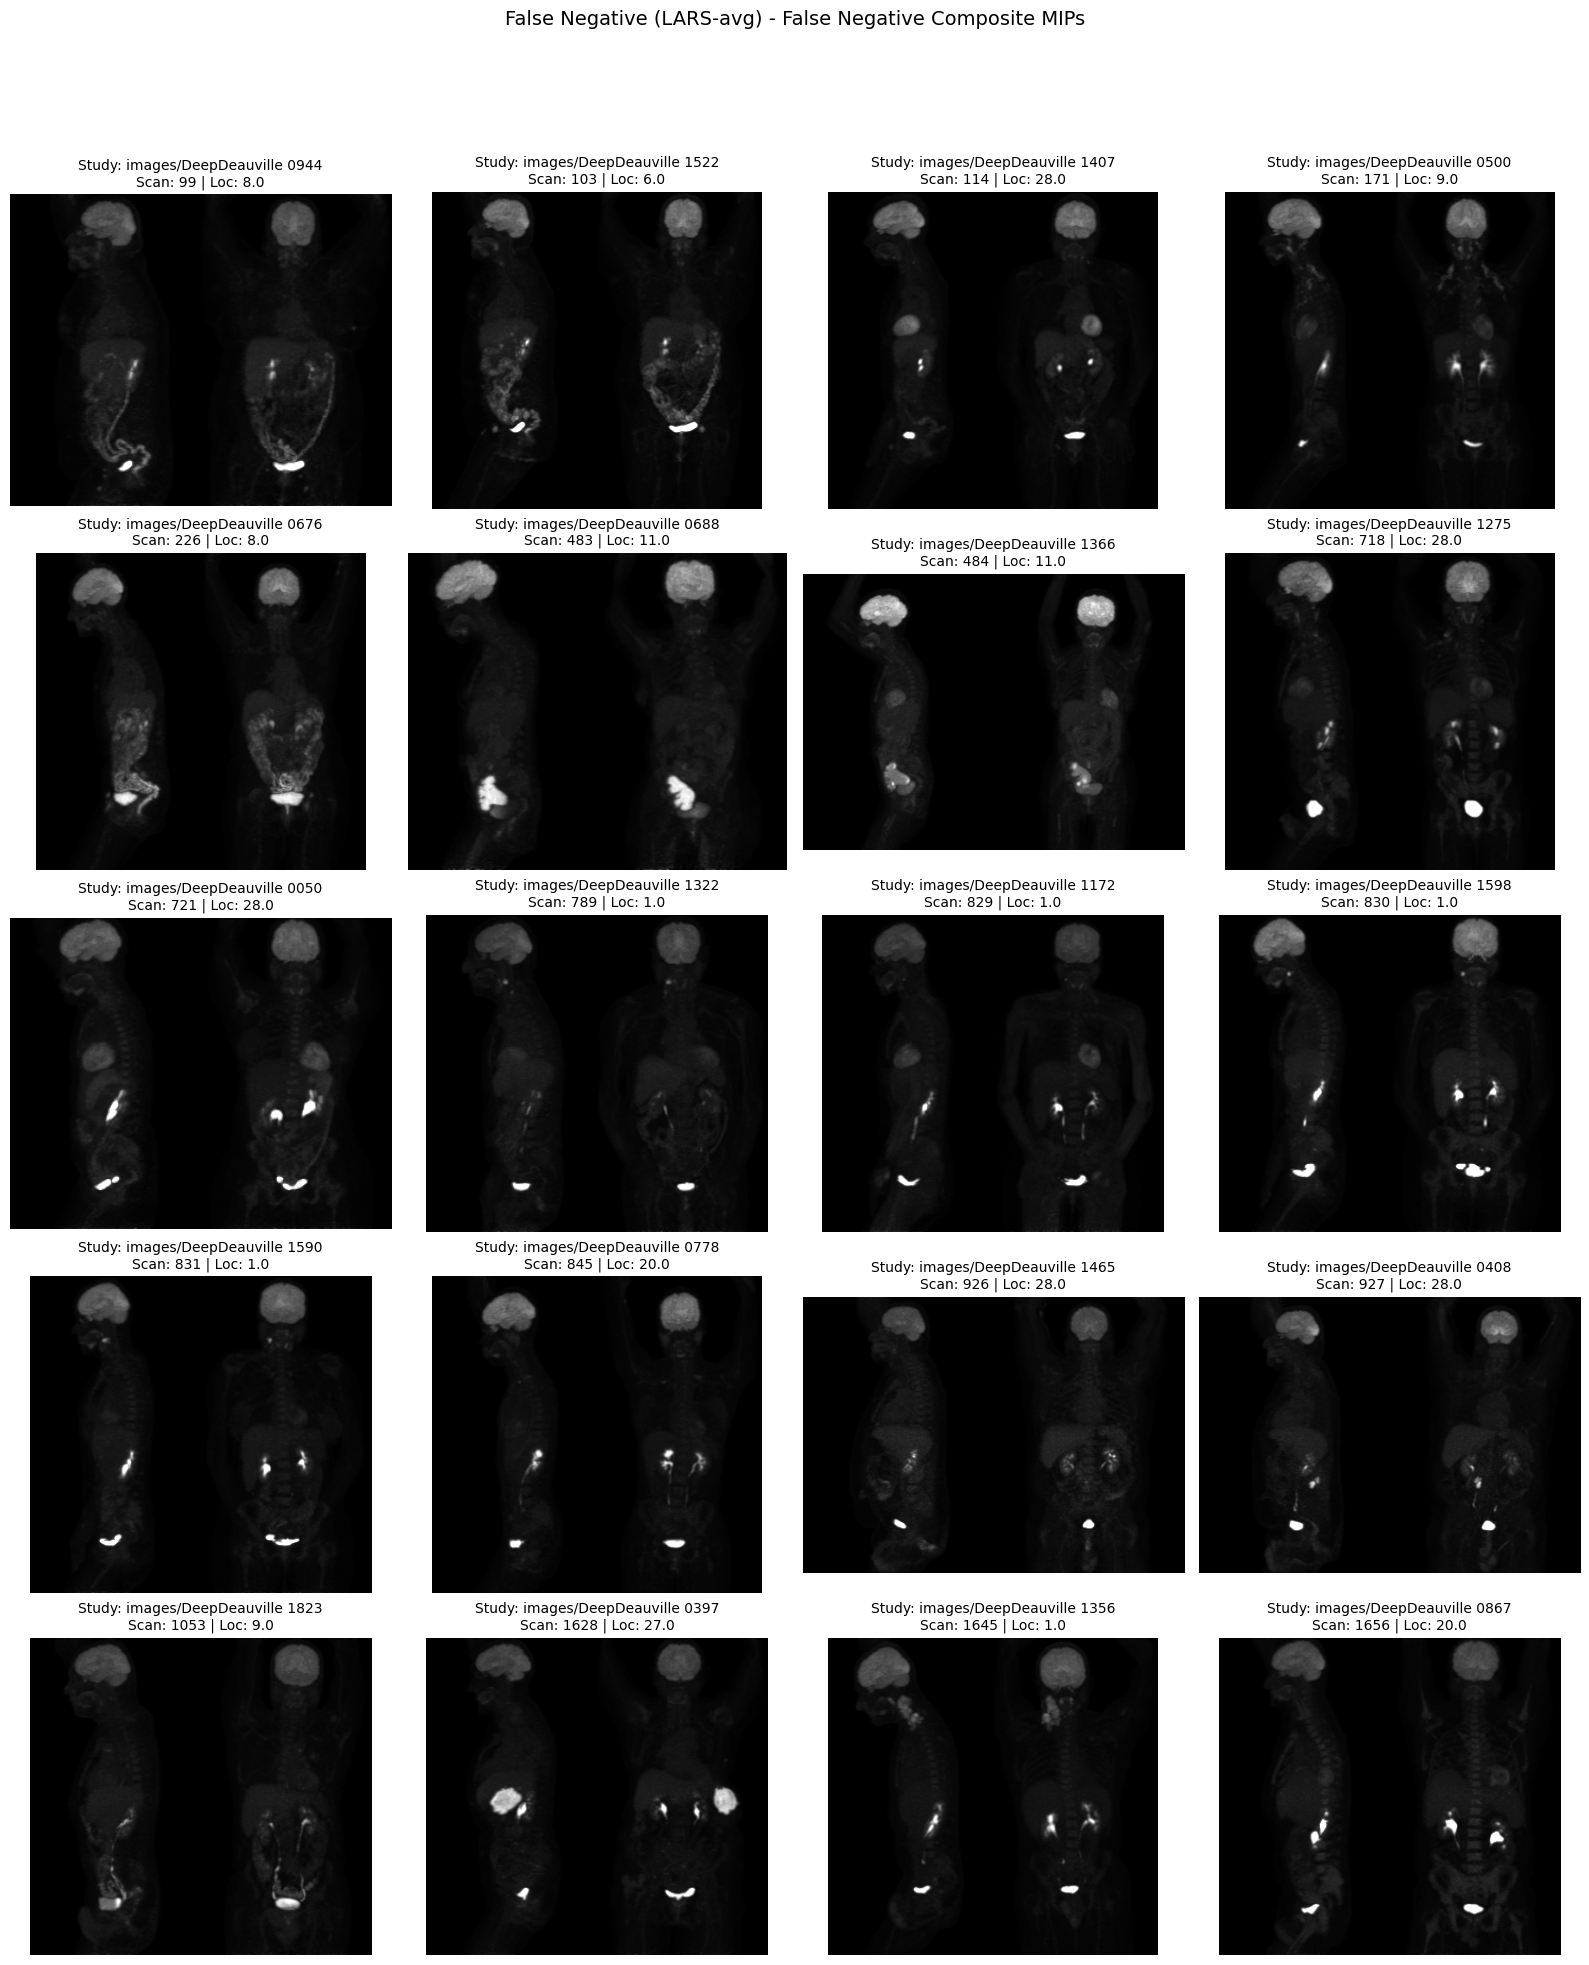


Displaying up to 18 false negative scans (False Negative (LARS-max))...


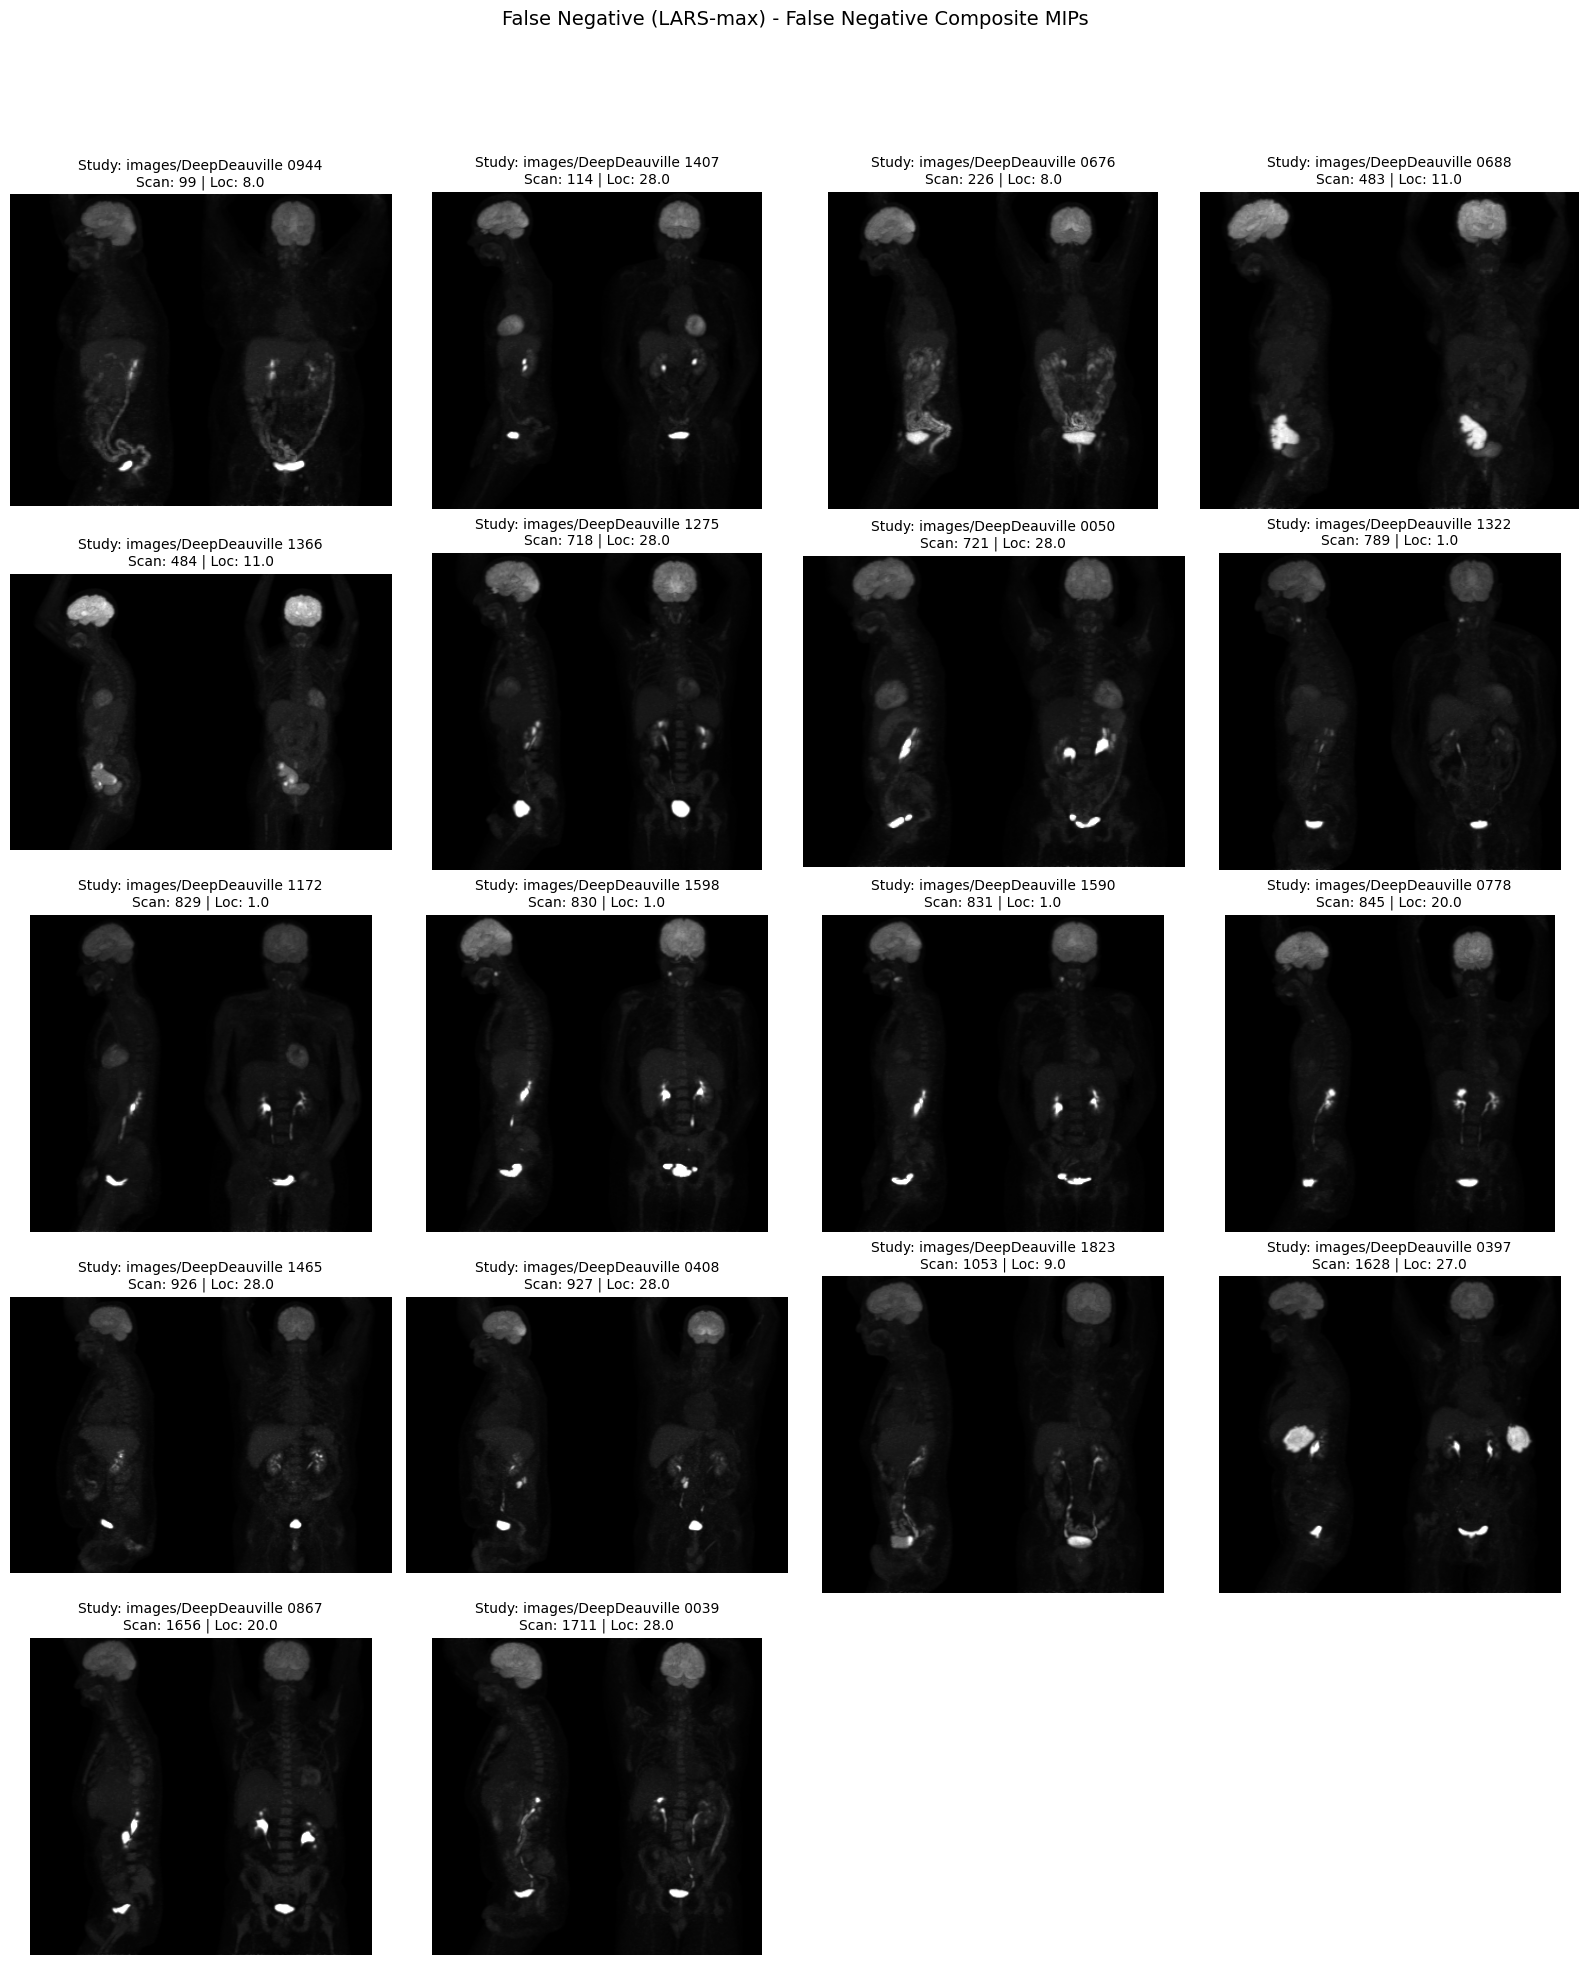

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

def show_false_negative_images_unique(fn_df, meta_df, title_prefix, base_path,
                                      norm=True, max_scans=12, n_cols=4):
    """
    Displays false negative images in a grid layout, ensuring each scan_id is processed only once.
    
    For each unique scan_id in fn_df, the function:
      - Looks up the sagittal and coronal filenames in meta_df (from the "filename" column).
      - Loads and normalizes the images from base_path (files assumed to be stored here).
      - Stacks them horizontally into a composite image.
      - Adds a title including the study ID (extracted from the filename), the scan ID, and the lesion localization.
    The composite images are then arranged in a grid with n_cols columns.
    
    Parameters:
      fn_df: DataFrame containing at least a 'scan_id' column for false negatives.
      meta_df: DataFrame from data.csv with columns ['scan_id', 'filename', 'target_loc'].
      title_prefix: A prefix for the overall title.
      base_path: Directory where the image .npy files are stored.
      norm: If True, clips pixel values to [0, 30] and rescales them to [0, 1].
      max_scans: Maximum number of false negative scans to display.
      n_cols: Number of columns in the grid.
    """
    # Get unique scan IDs so each is processed only once
    unique_scan_ids = fn_df['scan_id'].drop_duplicates().head(max_scans)
    print(f"\nDisplaying up to {len(unique_scan_ids)} false negative scans ({title_prefix})...")

    composite_images = []
    titles = []
    
    for scan_id in unique_scan_ids:
        # Filter meta_df for the current scan_id
        df_scan = meta_df[meta_df['scan_id'] == scan_id]
        
        # Look for filenames containing '_sag' and '_cor'
        sag_rows = df_scan[df_scan['filename'].str.contains('_sag')]
        cor_rows = df_scan[df_scan['filename'].str.contains('_cor')]
        
        if sag_rows.empty or cor_rows.empty:
            print(f"Skipping scan_id {scan_id}: missing either sagittal or coronal image.")
            continue
        
        # Grab the first row for each
        sag_filename = sag_rows.iloc[0]['filename']
        cor_filename = cor_rows.iloc[0]['filename']
        target_loc = df_scan.iloc[0]['target_loc']
        
        # Extract study ID by removing the suffix '_sag.npy' or '_cor.npy'
        study_id = (sag_filename.replace('_sag.npy', '')
                                 .replace('_cor.npy', ''))
        
        # Build full paths
        sag_path = os.path.join(base_path, sag_filename)
        cor_path = os.path.join(base_path, cor_filename)
        
        try:
            sag_img = np.load(sag_path)
            cor_img = np.load(cor_path)
            
            # Normalize if requested
            if norm:
                sag_img = np.clip(sag_img, 0, 30)
                sag_img = (sag_img - sag_img.min()) / (sag_img.max() - sag_img.min() + 1e-6)
                cor_img = np.clip(cor_img, 0, 30)
                cor_img = (cor_img - cor_img.min()) / (cor_img.max() - cor_img.min() + 1e-6)
            
            # Stack the sagittal and coronal MIPs horizontally
            composite = np.hstack((sag_img, cor_img))
            composite_images.append(composite)
            
            # Title includes study ID, scan ID, and localization
            titles.append(f"Study: {study_id}\nScan: {scan_id} | Loc: {target_loc}")
        except Exception as e:
            print(f"Error loading images for scan_id {scan_id} (Study: {study_id}): {e}")

    # If no composite images were created, just return
    if not composite_images:
        print("No composite images to display.")
        return

    # Plot them in a grid
    n_images = len(composite_images)
    n_rows = math.ceil(n_images / n_cols)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axs = np.atleast_1d(axs).flatten()
    
    for i in range(n_rows * n_cols):
        ax = axs[i]
        if i < n_images:
            ax.imshow(composite_images[i], cmap='gray')
            ax.set_title(titles[i], fontsize=10)
        ax.axis('off')
    
    plt.suptitle(f"{title_prefix} - False Negative Composite MIPs", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# Example usage:
show_false_negative_images_unique(fn_avg_info, meta_df, "False Negative (LARS-avg)",
    base_path="/home/mezher/Documents/Deauville_DeepLearning/splitting",
    norm=True, max_scans=20, n_cols=4)

show_false_negative_images_unique(fn_max_info, meta_df, "False Negative (LARS-max)",
    base_path="/home/mezher/Documents/Deauville_DeepLearning/splitting",
    norm=True, max_scans=20, n_cols=4)


Overall Metrics:
Accuracy: 0.864
Precision: 0.600
Recall: 0.650
F1 Score: 0.624

Quick Commentary:
- Accuracy is the proportion of correctly classified scans overall.
- Precision indicates how many of the scans predicted as positive are truly positive.
- Recall (sensitivity) tells you what proportion of actual positive scans were detected.
- F1 Score is the harmonic mean of precision and recall, balancing both metrics.

Confusion Matrix:
[[259  26]
 [ 21  39]]


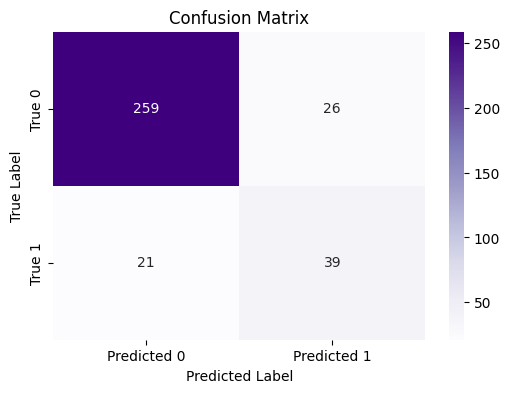

Sensitivity: 0.650, same as recall
Specificity: 0.909

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       285
           1       0.60      0.65      0.62        60

    accuracy                           0.86       345
   macro avg       0.76      0.78      0.77       345
weighted avg       0.87      0.86      0.87       345

Number of False Positives: 26
Number of False Negatives: 21


In [5]:
# -----------------------------
# 1. Load Predictions and Compute Metrics
# -----------------------------

# Choose which ensemble file to use: "ensemble_avg.csv" for LARS-avg variant or "ensemble_max.csv" for LARS-max variant
df_preds = ensemble_avg

# Ensure required columns exist: 'scan_id', 'target', 'ensemble_prob', and 'pred_label'
# Here, it is assumed that 'pred_label' has already been computed based on an optimal threshold.
y_true = df_preds['target']
y_pred = df_preds['pred_label']

# Compute common metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Overall Metrics:")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}\n")

print("Quick Commentary:")
print("- Accuracy is the proportion of correctly classified scans overall.")
print("- Precision indicates how many of the scans predicted as positive are truly positive.")
print("- Recall (sensitivity) tells you what proportion of actual positive scans were detected.")
print("- F1 Score is the harmonic mean of precision and recall, balancing both metrics.\n")



# Compute and display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
sns.color_palette("viridis", as_cmap=True)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)
print(f"Sensitivity: {sensitivity:.3f}, same as recall")
print(f"Specificity: {specificity:.3f}\n")


# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# -----------------------------
# 2. Identify Misclassified Cases
# -----------------------------

false_positives = df_preds[(df_preds['target'] == 0) & (df_preds['pred_label'] == 1)]
false_negatives = df_preds[(df_preds['target'] == 1) & (df_preds['pred_label'] == 0)]

print("Number of False Positives:", len(false_positives))
print("Number of False Negatives:", len(false_negatives))


Overall Metrics:
Accuracy: 0.835
Precision: 0.519
Recall: 0.700
F1 Score: 0.596

Quick Commentary:
- Accuracy is the proportion of correctly classified scans overall.
- Precision indicates how many of the scans predicted as positive are truly positive.
- Recall (sensitivity) tells you what proportion of actual positive scans were detected.
- F1 Score is the harmonic mean of precision and recall, balancing both metrics.

Confusion Matrix:
[[246  39]
 [ 18  42]]


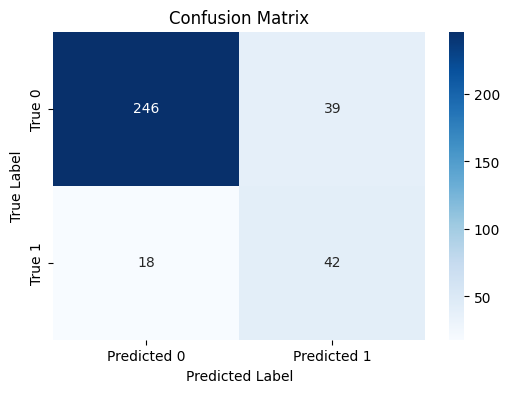

Sensitivity: 0.700, same as recall
Specificity: 0.863

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.90       285
           1       0.52      0.70      0.60        60

    accuracy                           0.83       345
   macro avg       0.73      0.78      0.75       345
weighted avg       0.86      0.83      0.84       345

Number of False Positives: 39
Number of False Negatives: 18


In [6]:
# -----------------------------
# 1. Load Predictions and Compute Metrics
# -----------------------------

# Choose which ensemble file to use: "ensemble_avg.csv" for LARS-avg variant or "ensemble_max.csv" for LARS-max variant
df_preds = ensemble_max

# Ensure required columns exist: 'scan_id', 'target', 'ensemble_prob', and 'pred_label'
# Here, it is assumed that 'pred_label' has already been computed based on an optimal threshold.
y_true = df_preds['target']
y_pred = df_preds['pred_label']

# Compute common metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Overall Metrics:")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}\n")

print("Quick Commentary:")
print("- Accuracy is the proportion of correctly classified scans overall.")
print("- Precision indicates how many of the scans predicted as positive are truly positive.")
print("- Recall (sensitivity) tells you what proportion of actual positive scans were detected.")
print("- F1 Score is the harmonic mean of precision and recall, balancing both metrics.\n")



# Compute and display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)
print(f"Sensitivity: {sensitivity:.3f}, same as recall")
print(f"Specificity: {specificity:.3f}\n")


# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# -----------------------------
# 2. Identify Misclassified Cases
# -----------------------------

false_positives = df_preds[(df_preds['target'] == 0) & (df_preds['pred_label'] == 1)]
false_negatives = df_preds[(df_preds['target'] == 1) & (df_preds['pred_label'] == 0)]

print("Number of False Positives:", len(false_positives))
print("Number of False Negatives:", len(false_negatives))


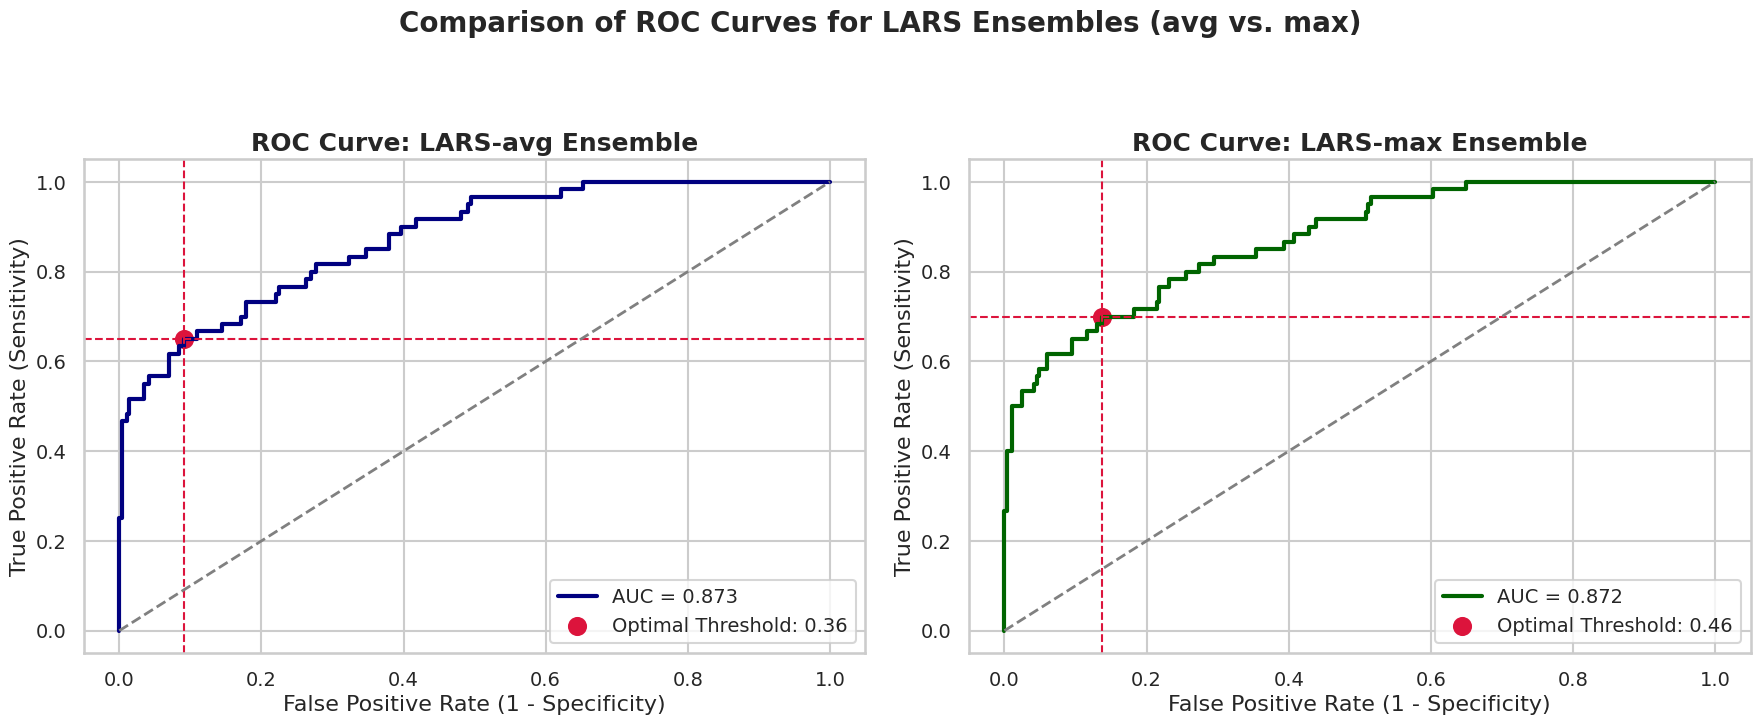

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

# Use seaborn style and context for improved aesthetics
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

# --- ROC Curve for LARS-avg Ensemble ---
fpr_avg, tpr_avg, thresholds_avg = roc_curve(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
roc_auc_avg = roc_auc_score(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
optimal_idx_avg = np.argmax(tpr_avg - fpr_avg)
optimal_threshold_avg = thresholds_avg[optimal_idx_avg]

# --- ROC Curve for LARS-max Ensemble ---
fpr_max, tpr_max, thresholds_max = roc_curve(ensemble_max['target'], ensemble_max['ensemble_prob'])
roc_auc_max = roc_auc_score(ensemble_max['target'], ensemble_max['ensemble_prob'])
optimal_idx_max = np.argmax(tpr_max - fpr_max)
optimal_threshold_max = thresholds_max[optimal_idx_max]

# Set up subplots with extra space for titles
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot ROC Curve for LARS-avg ---
axes[0].plot(fpr_avg, tpr_avg, color='navy', lw=3, label=f'AUC = {roc_auc_avg:.3f}')
axes[0].scatter(fpr_avg[optimal_idx_avg], tpr_avg[optimal_idx_avg], color='crimson', marker='o', s=150, label=f'Optimal Threshold: {optimal_threshold_avg:.2f}')
axes[0].axvline(fpr_avg[optimal_idx_avg], color='crimson', linestyle='--', lw=1.5)
axes[0].axhline(tpr_avg[optimal_idx_avg], color='crimson', linestyle='--', lw=1.5)
axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
axes[0].set_title('ROC Curve: LARS-avg Ensemble', fontsize=18, fontweight='bold')
axes[0].set_xlabel('False Positive Rate (1 - Specificity)', fontsize=16)
axes[0].set_ylabel('True Positive Rate (Sensitivity)', fontsize=16)
axes[0].legend(loc='lower right', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=14)

# --- Plot ROC Curve for LARS-max ---
axes[1].plot(fpr_max, tpr_max, color='darkgreen', lw=3, label=f'AUC = {roc_auc_max:.3f}')
axes[1].scatter(fpr_max[optimal_idx_max], tpr_max[optimal_idx_max], color='crimson', marker='o', s=150, label=f'Optimal Threshold: {optimal_threshold_max:.2f}')
axes[1].axvline(fpr_max[optimal_idx_max], color='crimson', linestyle='--', lw=1.5)
axes[1].axhline(tpr_max[optimal_idx_max], color='crimson', linestyle='--', lw=1.5)
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
axes[1].set_title('ROC Curve: LARS-max Ensemble', fontsize=18, fontweight='bold')
axes[1].set_xlabel('False Positive Rate (1 - Specificity)', fontsize=16)
axes[1].set_ylabel('True Positive Rate (Sensitivity)', fontsize=16)
axes[1].legend(loc='lower right', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)

plt.suptitle('Comparison of ROC Curves for LARS Ensembles (avg vs. max)', fontsize=20, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()
